In [8]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

import random
from deap import base, creator, tools, algorithms

# Tank 模型原理

一个简单的Tank模型（水箱模型）可以用来描述水文过程，包括入流、出流、蒸散发和降水。以下是一个简单的Tank模型的Python实现。这个实现是基于一个有两个水箱的模型，第一个水箱（上游水箱）用于处理降水和蒸散发，第二个水箱（下游水箱）用于处理出流。

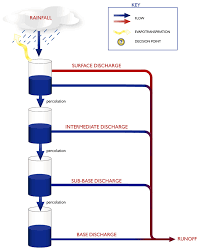

In [9]:
mete = pd.read_csv('../data/intermediate/mete_processed.csv', index_col=0, parse_dates=True)
fengqiao = pd.read_csv('../data/intermediate/fengqiao_interpolated.csv', index_col=0, parse_dates=True)

In [6]:
def tank_model(precip, et, k1, k2, A, kc, initial_storage1=0, initial_storage2=0):
    n = len(precip)
    storage1 = np.zeros(n)
    storage2 = np.zeros(n)
    outflow = np.zeros(n)
    
    storage1[0] = initial_storage1
    storage2[0] = initial_storage2
    
    for t in range(1, n):
        # 计算实际蒸散发
        et_actual = et[t] * kc
        
        # 第一个水箱（上游水箱）处理降水和蒸散发
        storage1[t] = storage1[t-1] + precip[t] * A / 86400 - et_actual * A / 86400
        
        # 当存储量小于0时，将其设置为0
        storage1[t] = max(0, storage1[t])
        
        # 第二个水箱（下游水箱）处理出流
        inflow = k1 * storage1[t]
        storage1[t] -= inflow
        storage2[t] = storage2[t-1] + inflow
        outflow[t] = k2 * storage2[t]
        storage2[t] -= outflow[t]
        
    return storage1, storage2, outflow

def model_error(k1, k2, A, kc, initial_storage1, initial_storage2, precip, et, discharge):
    _, _, outflow = tank_model(precip, et, k1, k2, A, kc, initial_storage1, initial_storage2)
    mse = mean_squared_error(discharge, outflow)
    return mse  

# 定义参数搜索范围
param_bounds = {
    'kc': (0.1, 1.5),
    'k1': (0.01, 0.5),
    'k2': (0.01, 0.5),
    'A': (0, 2000000),
    'initial_storage1': (0, 10000),  # 假设初始存储量1的范围为0到100000立方米
    'initial_storage2': (0, 10000),  # 假设初始存储量2的范围为0到100000立方米
}

# 贝叶斯优化

先需要将precipitation和ETo转换为m³/s的单位。考虑到1mm/day的降水和蒸散发相当于1m³每平方米每天，我们可以使用流域面积（以平方米为单位）将它们转换为m³/s。 假设流域面积为A（平方米），我们可以按照以下步骤进行修改：

将降水和蒸散发单位从mm/day转换为m³/s。修改tank_model函数以接收流域面积作为参数。

这里对比两种蒸散发的预测结果，HS和PM两种。


|   iter    |  target   |     A     | initia... | initia... |    k1     |    k2     |    kc     |
-------------------------------------------------------------------------------------------------
| 1         | 2.424e+03 | 7.491e+05 | 9.507e+03 | 7.32e+03  | 0.3033    | 0.08645   | 0.3184    |
| 2         | 3.092e+03 | 1.162e+05 | 8.662e+03 | 6.011e+03 | 0.357     | 0.02009   | 1.458     |
| 3         | 2.125e+03 | 1.665e+06 | 2.123e+03 | 1.818e+03 | 0.09987   | 0.1591    | 0.8347    |
| 4         | 2.238e+03 | 8.639e+05 | 2.912e+03 | 6.119e+03 | 0.07835   | 0.1532    | 0.6129    |
| 5         | 2.668e+03 | 9.121e+05 | 7.852e+03 | 1.997e+03 | 0.262     | 0.3003    | 0.165     |
| 6         | 3.895e+03 | 1.215e+06 | 1.705e+03 | 650.5     | 0.475     | 0.4832    | 1.232     |
| 7         | 2.147e+03 | 6.092e+05 | 976.7     | 6.842e+03 | 0.2257    | 0.0698    | 0.7932    |
| 8         | 3.703e+03 | 6.878e+04 | 9.093e+03 | 2.588e+03 | 0.3346    | 0.1627    | 0.8281    |
| 9         | 5.897e

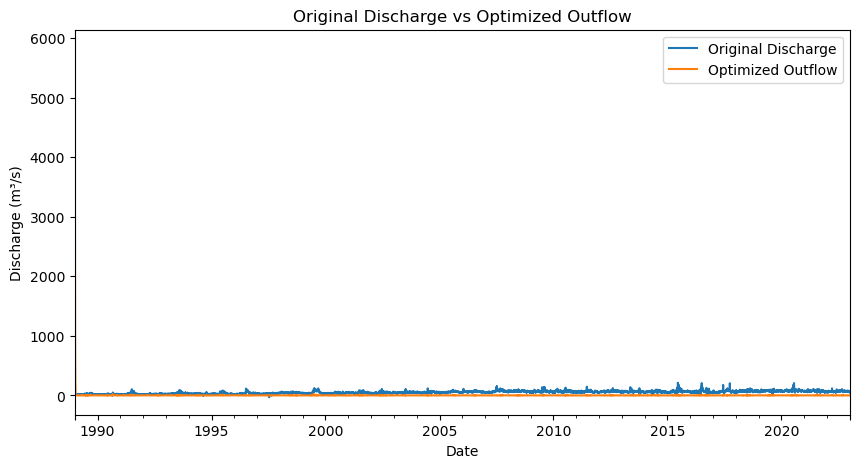

In [7]:
# 创建优化器
optimizer = BayesianOptimization(
    f=lambda k1, k2, A, initial_storage1, initial_storage2, kc: model_error(k1, k2, A, kc, initial_storage1, initial_storage2, fengqiao['precipitation'], mete['ETo_PM'], fengqiao['discharge']),
    pbounds=param_bounds,
    random_state=42,
)

# 执行优化
optimizer.maximize(init_points=10, n_iter=50)

# 获取最佳参数
best_params = optimizer.max['params']

# 使用最佳参数重新运行模型
kc_opt = best_params['kc']
k1_opt = best_params['k1']
k2_opt = best_params['k2']
A_opt = best_params['A']
initial_storage1_opt = best_params['initial_storage1']
initial_storage2_opt = best_params['initial_storage2']
storage1_opt, storage2_opt, outflow_opt = tank_model(fengqiao['precipitation'], mete['ETo_PM'], k1_opt, k2_opt, A_opt, kc_opt, initial_storage1_opt, initial_storage2_opt)

# 将优化后的结果存储在一个新的DataFrame中
tank_results_opt = pd.DataFrame({'Date': mete.index, 'Storage1': storage1_opt, 'Storage2': storage2_opt, 'Outflow': outflow_opt})
tank_results_opt.set_index('Date', inplace=True)

# Calculate the mean squared error between the original and optimized discharge
mse = mean_squared_error(fengqiao['discharge'], tank_results_opt['Outflow'])

print(tank_results_opt)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

# 绘制原始的discharge数据
fengqiao['discharge'].plot(ax=ax, label='Original Discharge')
print('Mean Squared Error:', mse)
# 绘制优化后的Outflow数据
tank_results_opt['Outflow'].plot(ax=ax, label='Optimized Outflow')

ax.set_title('Original Discharge vs Optimized Outflow')
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (m³/s)')
ax.legend()

plt.show()


在某些情况下，优化可能无法得到理想的结果。这可能是由于参数范围、优化算法或模型本身的局限性导致的。要尝试改善结果，可以尝试以下方法：

调整参数范围：可能是某些参数的搜索范围过于宽泛或过于狭窄。尝试根据你对问题的领域知识或之前的研究来调整参数范围。

增加优化迭代次数：增加n_iter的值可以使贝叶斯优化有更多的机会找到更好的参数组合。尝试将n_iter增加到100或200，看看是否能找到更好的结果。

选择其他优化算法：尽管贝叶斯优化是一种有效的参数优化方法，但也可以尝试其他优化算法，如scipy.optimize.minimize或sklearn.model_selection.GridSearchCV。这些方法可能在某些情况下表现更好。

检查模型：确保你的水箱模型正确实现了你期望的计算。在某些情况下，模型本身可能无法捕捉到数据中的关系，这时可能需要调整模型的结构或假设。

数据预处理：检查输入数据，确保它们都在合理的范围内。在某些情况下，数据清洗或预处理可能有助于改善模型性能。尝试对输入数据进行归一化或标准化，看看是否能改善结果。

|   iter    |  target   |     A     | initia... | initia... |    k1     |    k2     |    kc     |
-------------------------------------------------------------------------------------------------
| 1         | -2.424e+0 | 7.491e+05 | 9.507e+03 | 7.32e+03  | 0.3033    | 0.08645   | 0.3184    |
| 2         | -3.092e+0 | 1.162e+05 | 8.662e+03 | 6.011e+03 | 0.357     | 0.02009   | 1.458     |
| 3         | -2.125e+0 | 1.665e+06 | 2.123e+03 | 1.818e+03 | 0.09987   | 0.1591    | 0.8347    |
| 4         | -2.238e+0 | 8.639e+05 | 2.912e+03 | 6.119e+03 | 0.07835   | 0.1532    | 0.6129    |
| 5         | -2.668e+0 | 9.121e+05 | 7.852e+03 | 1.997e+03 | 0.262     | 0.3003    | 0.165     |
| 6         | -3.895e+0 | 1.215e+06 | 1.705e+03 | 650.5     | 0.475     | 0.4832    | 1.232     |
| 7         | -2.147e+0 | 6.092e+05 | 976.7     | 6.842e+03 | 0.2257    | 0.0698    | 0.7932    |
| 8         | -3.703e+0 | 6.878e+04 | 9.093e+03 | 2.588e+03 | 0.3346    | 0.1627    | 0.8281    |
| 9         | -5.897

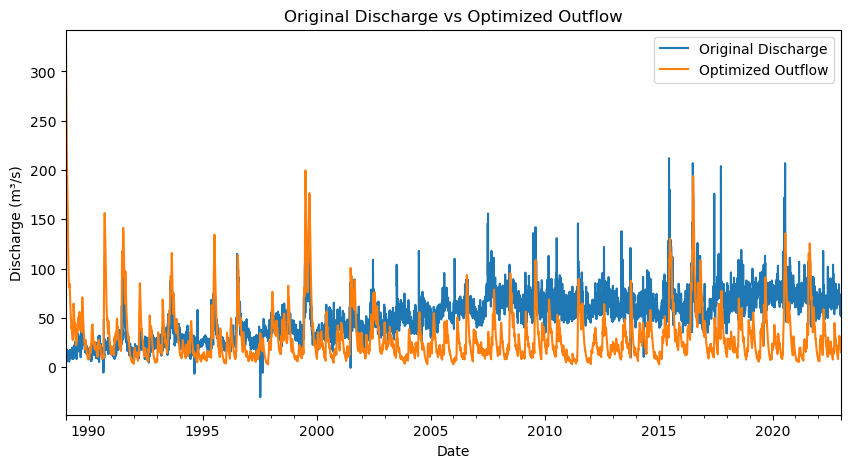

In [10]:
def tank_model(precip, et, k1, k2, A, kc, initial_storage1=0, initial_storage2=0):
    n = len(precip)
    storage1 = np.zeros(n)
    storage2 = np.zeros(n)
    outflow = np.zeros(n)
    
    storage1[0] = initial_storage1
    storage2[0] = initial_storage2
    
    for t in range(1, n):
        # 计算实际蒸散发
        et_actual = et[t] * kc
        
        # 第一个水箱（上游水箱）处理降水和蒸散发
        storage1[t] = storage1[t-1] + precip[t] * A / 86400 - et_actual * A / 86400
        
        # 当存储量小于0时，将其设置为0
        storage1[t] = max(0, storage1[t])
        
        # 第二个水箱（下游水箱）处理出流
        inflow = k1 * storage1[t]
        storage1[t] -= inflow
        storage2[t] = storage2[t-1] + inflow
        outflow[t] = k2 * storage2[t]
        storage2[t] -= outflow[t]
        
    return storage1, storage2, outflow

def model_error(k1, k2, A, kc, initial_storage1, initial_storage2, precip, et, discharge):
    _, _, outflow = tank_model(precip, et, k1, k2, A, kc, initial_storage1, initial_storage2)
    mse = mean_squared_error(discharge, outflow)
    return -mse  # 取负值，因为我们希望最大化贝叶斯优化函数

# 定义参数搜索范围
param_bounds = {
    'kc': (0.1, 1.5),
    'k1': (0.01, 0.5),
    'k2': (0.01, 0.5),
    'A': (0, 2000000),
    'initial_storage1': (0, 10000),  # 假设初始存储量1的范围为0到100000立方米
    'initial_storage2': (0, 10000),  # 假设初始存储量2的范围为0到100000立方米
}

# 创建优化器
optimizer = BayesianOptimization(
    f=lambda k1, k2, A, initial_storage1, initial_storage2, kc: model_error(k1, k2, A, kc, initial_storage1, initial_storage2, fengqiao['precipitation'], mete['ETo_PM'], fengqiao['discharge']),
    pbounds=param_bounds,
    random_state=42,
)

# 执行优化
optimizer.maximize(init_points=10, n_iter=50)

# 获取最佳参数
best_params = optimizer.max['params']

# 使用最佳参数重新运行模型
kc_opt = best_params['kc']
k1_opt = best_params['k1']
k2_opt = best_params['k2']
A_opt = best_params['A']
initial_storage1_opt = best_params['initial_storage1']
initial_storage2_opt = best_params['initial_storage2']
storage1_opt, storage2_opt, outflow_opt = tank_model(fengqiao['precipitation'], mete['ETo_PM'], k1_opt, k2_opt, A_opt, kc_opt, initial_storage1_opt, initial_storage2_opt)

# 将优化后的结果存储在一个新的DataFrame中
tank_results_opt = pd.DataFrame({'Date': mete.index, 'Storage1': storage1_opt, 'Storage2': storage2_opt, 'Outflow': outflow_opt})
tank_results_opt.set_index('Date', inplace=True)

# Calculate the mean squared error between the original and optimized discharge
mse = mean_squared_error(fengqiao['discharge'], tank_results_opt['Outflow'])

print(tank_results_opt)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

# 绘制原始的discharge数据
fengqiao['discharge'].plot(ax=ax, label='Original Discharge')
print('Mean Squared Error:', mse)
# 绘制优化后的Outflow数据
tank_results_opt['Outflow'].plot(ax=ax, label='Optimized Outflow')

ax.set_title('Original Discharge vs Optimized Outflow')
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (m³/s)')
ax.legend()

plt.show()


对比两种蒸散发结果，总体来看PM更能捕捉到discharge高水位的变化；但是在整体上，HS的蒸散发更能捕捉到discharge的变化。

两种方法都可以用于估计参考作物蒸散发并反映出气候变化，但PM方法在考虑更多气象因素的同时，也更能反映植被变化。

## 遗传算法

In [28]:
def Tank_model_evap(ETo):
    # Create types
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    # Register functions
    toolbox = base.Toolbox()

    # 将连续变量转换为浮点数
    def random_float(low, high):
        return random.uniform(low, high)

    toolbox.register("attr_kc", random_float, 0.1, 1.5)
    toolbox.register("attr_k1", random_float, 0.01, 0.5)
    toolbox.register("attr_k2", random_float, 0.01, 0.5)
    toolbox.register("attr_A", random_float, 0, 2000000)
    toolbox.register("attr_initial_storage1", random_float, 0, 10000)
    toolbox.register("attr_initial_storage2", random_float, 0, 10000)

    toolbox.register(
        "individual",
        tools.initCycle,
        creator.Individual,
        (
            toolbox.attr_kc,
            toolbox.attr_k1,
            toolbox.attr_k2,
            toolbox.attr_A,
            toolbox.attr_initial_storage1,
            toolbox.attr_initial_storage2,
        ),
        n=1,
    )

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxUniform, indpb=0.5)
    toolbox.register("mutate", tools.mutPolynomialBounded, eta=20, low=[param_bounds['kc'][0], param_bounds['k1'][0], param_bounds['k2'][0], param_bounds['A'][0], param_bounds['initial_storage1'][0], param_bounds['initial_storage2'][0]], up=[param_bounds['kc'][1], param_bounds['k1'][1], param_bounds['k2'][1], param_bounds['A'][1], param_bounds['initial_storage1'][1], param_bounds['initial_storage2'][1]], indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)

    def evaluate(individual):
        kc, k1, k2, A, initial_storage1, initial_storage2 = individual
        return (model_error(k1, k2, A, kc, initial_storage1, initial_storage2, fengqiao["precipitation"], ETo, fengqiao["discharge"]),)

    toolbox.register("evaluate", evaluate)

    # Parameters
    population_size = 50
    num_generations = 100
    cxpb = 0.5
    mutpb = 0.2

    # Initialize population
    population = toolbox.population(n=population_size)

    # Evolve the population
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=num_generations, stats=stats, verbose=True)

    # Extract the best individual
    best_ind = tools.selBest(population, 1)[0]
    print("Best individual:", best_ind, "Fitness:", best_ind.fitness.values[0])

    # Unpack the best individual's parameters
    kc, k1, k2, A, initial_storage1, initial_storage2 = best_ind

    # Run the tank model with the best parameters
    storage1, storage2, outflow = tank_model(
        fengqiao["precipitation"],
        ETo,
        k1,
        k2,
        A,
        kc,
        initial_storage1,
        initial_storage2,
    )

    # Plot the original data
    plt.plot(fengqiao.index, fengqiao["discharge"], label="Observed")

    # Run the tank model with the best parameters
    storage1, storage2, outflow = tank_model(
        fengqiao["precipitation"],
        ETo,
        k1,
        k2,
        A,
        kc,
        initial_storage1,
        initial_storage2,
    )

    # Plot the optimized results
    plt.plot(fengqiao.index, outflow, label="Simulated")

    # Add labels and legend
    plt.xlabel("Date")
    plt.ylabel("Discharge (m³/s)")
    plt.legend()

    # Show the plot
    plt.show()

/home/zheng-s/anaconda3/envs/py39/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/zheng-s/anaconda3/envs/py39/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min    
0  	50    	1065.97
1  	30    	1148.78
2  	29    	894.5  
3  	30    	838.633
4  	29    	775.857
5  	23    	775.857
6  	35    	722.749
7  	27    	716.244
8  	29    	696.007
9  	28    	696.007
10 	32    	688.996
11 	24    	688.996
12 	35    	685.67 
13 	26    	669.638
14 	31    	669.579
15 	28    	661.135
16 	32    	655.18 
17 	29    	651.845
18 	29    	644.389
19 	35    	644.389
20 	26    	639.448
21 	16    	639.448
22 	19    	631.328
23 	28    	630.768
24 	29    	630.768
25 	34    	630.768
26 	23    	630.689
27 	39    	627.831
28 	32    	627.17 
29 	35    	627.17 
30 	28    	627.17 
31 	31    	624.707
32 	28    	624.707
33 	32    	623.738
34 	31    	623.214
35 	30    	623.214
36 	31    	622.281
37 	31    	622.148
38 	25    	621.744
39 	30    	621.185
40 	32    	621.185
41 	31    	620.467
42 	32    	620.404
43 	25    	619.881
44 	35    	619.855
45 	36    	619.827
46 	30    	619.513
47 	32    	619.513
48 	34    	619.122
49 	33    	618.909
50 	28    	618.854
51 	32    	6

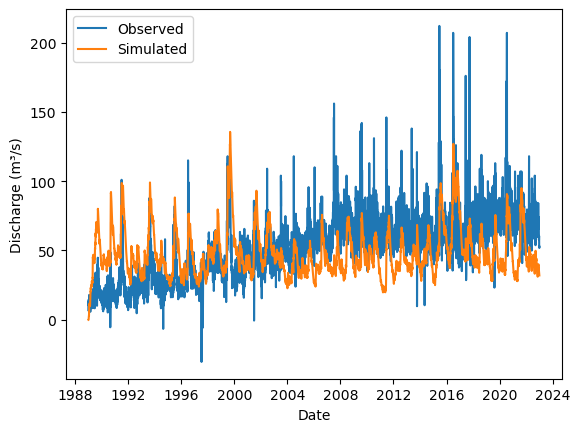

In [29]:
Tank_model_evap(mete['ETo_HS'])

/home/zheng-s/anaconda3/envs/py39/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/zheng-s/anaconda3/envs/py39/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min    
0  	50    	930.361
1  	31    	930.361
2  	28    	930.361
3  	23    	800.336
4  	33    	800.336
5  	27    	792.355
6  	24    	753.891
7  	24    	694.814
8  	33    	694.814
9  	34    	694.413
10 	38    	687.185
11 	25    	684.209
12 	32    	663.291
13 	29    	661.952
14 	26    	661.952
15 	19    	659.751
16 	28    	659.261
17 	30    	656.25 
18 	28    	656.25 
19 	30    	654.233
20 	21    	652.816
21 	27    	652.458
22 	32    	650.775
23 	17    	650.775
24 	26    	650.775
25 	26    	650.495
26 	32    	649.285
27 	33    	649.198
28 	29    	649.198
29 	35    	649.079
30 	29    	647.867
31 	20    	647.867
32 	34    	647.762
33 	36    	647.609
34 	25    	647.42 
35 	29    	647.13 
36 	23    	646.706
37 	29    	646.592
38 	26    	646.592
39 	25    	645.324
40 	28    	645.324
41 	25    	645.324
42 	31    	645.246
43 	36    	644.953
44 	24    	644.502
45 	31    	644.477
46 	22    	644.286
47 	28    	644.26 
48 	37    	644.194
49 	31    	643.613
50 	34    	643.165
51 	31    	6

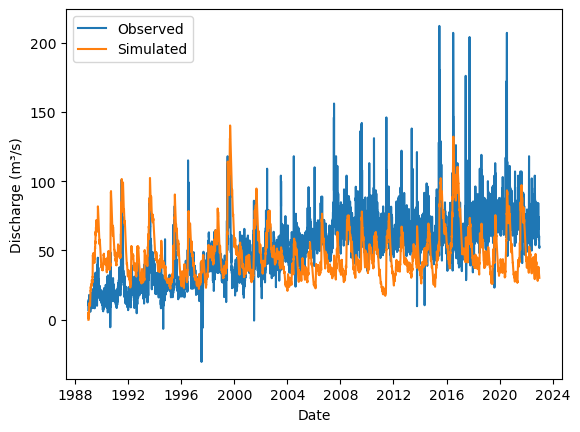

In [35]:
Tank_model_evap(mete['ETo_PM'])

使用遗传算法优化后的结果发现，最终两种蒸散发模型在这个水文模型中没有太大的出入；在前一节相关性证明中，两种方法计算结果相关性达到0.87侧面验证了这一结果。

调整模型参数：尝试使用不同的参数值，以找到更好地反映径流上升趋势的参数组合。遗传算法已经为您提供了一个很好的起点，您可以在其基础上进行微调。您还可以尝试其他优化方法，如梯度下降、模拟退火等，以进一步优化模型参数。

# 评估优化后的模型

Tank模型主要用于模拟流域的径流和蓄水过程，它的参数和初始条件通常是通过拟合历史数据来确定的。然而，随着时间的推移，气候变化、土地利用变化等因素可能会影响径流和蓄水过程，导致模型预测的趋势不准确。为了使Tank模型具有趋势性的变化预测能力，你可以尝试以下方法：

1. 引入气候变化或土地利用变化的信息：你可以考虑将气候变化的影响（例如，降水和蒸散发的变化趋势）或土地利用变化（例如，城市化和植被覆盖的变化）纳入模型。这可以通过在模型中引入额外的输入变量或参数来实现，以反映这些影响。

2. 动态参数调整：随着时间的推移，你可以根据观测到的新数据动态地调整模型参数。这可以通过在线学习算法或滚动窗口方法实现，以便在新的时间段内更新模型参数。这种方法可以使模型在时间尺度上更具适应性，从而提高预测趋势的准确性。

3. 采用具有趋势捕捉能力的机器学习方法：除了改进Tank模型之外，还可以尝试采用具有趋势捕捉能力的机器学习方法，例如长短时记忆神经网络（LSTM）或支持向量机（SVM）。这些方法可以自动捕捉输入数据的复杂模式和趋势，从而提高预测的准确性。

需要注意的是，在调整模型时，不仅要关注预测趋势的准确性，还要关注模型的可解释性和稳定性。在引入新的输入变量或参数时，请确保有足够的理论支持和观测数据来支持这些改进。

#  Physical informaled machine leanrning 

要将Tank模型改造成物理信息机器学习（Physically Informed Machine Learning，简称PIML）方法，您需要将基于物理原理的模型与数据驱动的机器学习方法相结合。以下是一种可能的方法：

1. 准备数据集：从您的数据集中提取输入特征（例如降雨、蒸散发等）以及输出目标（例如径流）。

2. 特征工程：在提取的特征中引入物理信息。例如，您可以使用Tank模型计算的中间变量（例如上游水箱和下游水箱的存储量）作为额外的输入特征。

3. 选择合适的机器学习模型：选择适用于回归问题的机器学习模型，如支持向量回归、随机森林回归、神经网络等。请注意，不同模型的性能可能因问题而异，因此您可能需要尝试多种模型，以找到最适合您问题的模型。

4. 训练和验证模型：将数据集分为训练集和验证集（如80%的训练数据和20%的验证数据）。使用训练数据拟合机器学习模型，并在验证数据上评估模型的性能。为了防止过拟合，您可以使用交叉验证技术（例如k-折交叉验证）。

5. 模型优化：调整模型的超参数，以找到最佳性能。您可以使用网格搜索、随机搜索或贝叶斯优化等方法进行超参数优化。

6. 测试模型：在最终测试数据集上评估模型性能，确保模型的泛化能力。

将物理信息和机器学习方法相结合，可以提高模型的预测能力，同时保留一定的物理解释性。这种方法在水文学、大气科学等领域取得了很好的效果。

# 改造水箱模型

## 基流分离

水箱模型可以修改以生成baseflow（基流）和direct runoff（直接径流）部分。一个简单的方法是将模型扩展为包含三个水箱，分别表示直接径流、基流和地下水。

In [48]:
def tank_model_baseflow_separation(precip, et, k1, k2, k3, A, kc, initial_storage1=0, initial_storage2=0, initial_storage3=0):
    n = len(precip)
    storage1 = np.zeros(n)
    storage2 = np.zeros(n)
    storage3 = np.zeros(n)
    direct_runoff = np.zeros(n)
    baseflow = np.zeros(n)
    outflow = np.zeros(n)
    
    storage1[0] = initial_storage1
    storage2[0] = initial_storage2
    storage3[0] = initial_storage3
    
    for t in range(1, n):
        # 计算实际蒸散发
        et_actual = et[t] * kc
        
        # 第一个水箱（上游水箱）处理降水和蒸散发
        storage1[t] = storage1[t-1] + precip[t] * A / 86400 - et_actual * A / 86400
        storage1[t] = max(0, storage1[t])
        
        # 第二个水箱（中游水箱）处理直接径流
        inflow = k1 * storage1[t]
        storage1[t] -= inflow
        storage2[t] = storage2[t-1] + inflow
        direct_runoff[t] = k2 * storage2[t]
        storage2[t] -= direct_runoff[t]
        
        # 第三个水箱（下游水箱）处理基流
        inflow_to_baseflow = k3 * storage2[t]
        storage2[t] -= inflow_to_baseflow
        storage3[t] = storage3[t-1] + inflow_to_baseflow
        baseflow[t] = k2 * storage3[t]
        storage3[t] -= baseflow[t]
        
        # 总出流量
        outflow[t] = direct_runoff[t] + baseflow[t]
        
    return storage1, storage2, storage3, direct_runoff, baseflow, outflow


现在设想同时对base flow 和direct runoff部分进行校核，可以先采用数学方法把discharge人为分成两部分，然后同时对两部分进行calibration校核。

### 滑动最小值法

滑动最小值法的基本思想是在给定时间窗口内找到流量最小值，将这些最小值作为基流，然后插值得到一个连续的基流时间序列。将总流量减去基流，就可以得到直接径流时间序列。

In [10]:
def baseflow_separation(discharge, window_size=5):
    n = len(discharge)
    baseflow = np.zeros(n)
    direct_runoff = np.zeros(n)

    for i in range(n):
        start = max(0, i - window_size)
        end = min(n, i + window_size)
        local_min = np.min(discharge[start:end])
        baseflow[i] = local_min

    direct_runoff = discharge - baseflow

    return baseflow, direct_runoff

In [11]:
def window_plot(window_size):
    baseflow_fengqiao, direct_runoff_fengqiao = baseflow_separation(fengqiao['discharge'], window_size=window_size)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6), sharey=True, sharex=False)

    ax1.plot(fengqiao.index, fengqiao['discharge'], label='discharge')
    ax1.plot(fengqiao.index, baseflow_fengqiao, label='baseflow')
    ax1.plot(fengqiao.index, direct_runoff_fengqiao, label='direct runoff')
    ax1.set_title('Fengqiao Discharge')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Flow (m$^3$/s)')

    idx = (fengqiao.index >= '2000-01-01') & (fengqiao.index <= '2000-12-31')
    ax2.plot(fengqiao.index[idx], fengqiao['discharge'][idx], label='discharge')
    ax2.plot(fengqiao.index[idx], baseflow_fengqiao[idx], label='baseflow')
    ax2.plot(fengqiao.index[idx], direct_runoff_fengqiao[idx], label='direct runoff')
    ax2.set_title('Discharge [2000-01-01,2000-12-31]')
    ax2.set_xlabel('Date')

    idx = (fengqiao.index >= '2000-01-01') & (fengqiao.index <= '2000-06-30')
    ax3.plot(fengqiao.index[idx], fengqiao['discharge'][idx], label='discharge')
    ax3.plot(fengqiao.index[idx], baseflow_fengqiao[idx], label='baseflow')
    ax3.plot(fengqiao.index[idx], direct_runoff_fengqiao[idx], label='direct runoff')
    ax3.set_title('Discharge [2000-01-01, 2000-06-30]')
    ax3.set_xlabel('Date')

    idx = (fengqiao.index >= '2000-01-01') & (fengqiao.index <= '2000-01-31')
    ax4.plot(fengqiao.index[idx], fengqiao['discharge'][idx], label='discharge')
    ax4.plot(fengqiao.index[idx], baseflow_fengqiao[idx], label='baseflow')
    ax4.plot(fengqiao.index[idx], direct_runoff_fengqiao[idx], label='direct runoff')
    ax4.set_title('Discharge [2000-01-01, 2000-01-31]')
    ax4.set_xlabel('Date')

    for ax in [ax1, ax2, ax3, ax4]:
        ax.legend()
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=30, ha='right')

    fig.tight_layout()
    plt.show()

如何判断所选窗口大小是否合适？

1. 基流平滑度：合适的窗口大小应产生平滑的基流时间序列，没有快速波动。如果基流时间序列中存在许多波动或锯齿状的波动，可能需要增大窗口大小以获得更平滑的基流。

2. 基流持续性：基流通常在雨季结束后仍然存在，因此合适的窗口大小应该能够捕捉到这种持续性。如果您的基流时间序列在干旱时期过早消失，这可能表明窗口大小不合适。

3. 直接径流反应：直接径流部分应反映出降水事件后的快速响应。如果直接径流的峰值与降水事件之间的时间延迟过长，或者直接径流中的峰值与降水事件无法形成对应关系，可能需要调整窗口大小。

4. 径流分离合理性：观察 base flow 和 direct runoff 之和是否与总的 discharge 时间序列相符。合适的窗口大小应使得 base flow 和 direct runoff 之和较好地还原总的 discharge 时间序列。

那么可以plot discharge使用不同的时间尺度，观察这4个特点是否满足。

In [3]:
window_plot(5)

NameError: name 'window_plot' is not defined

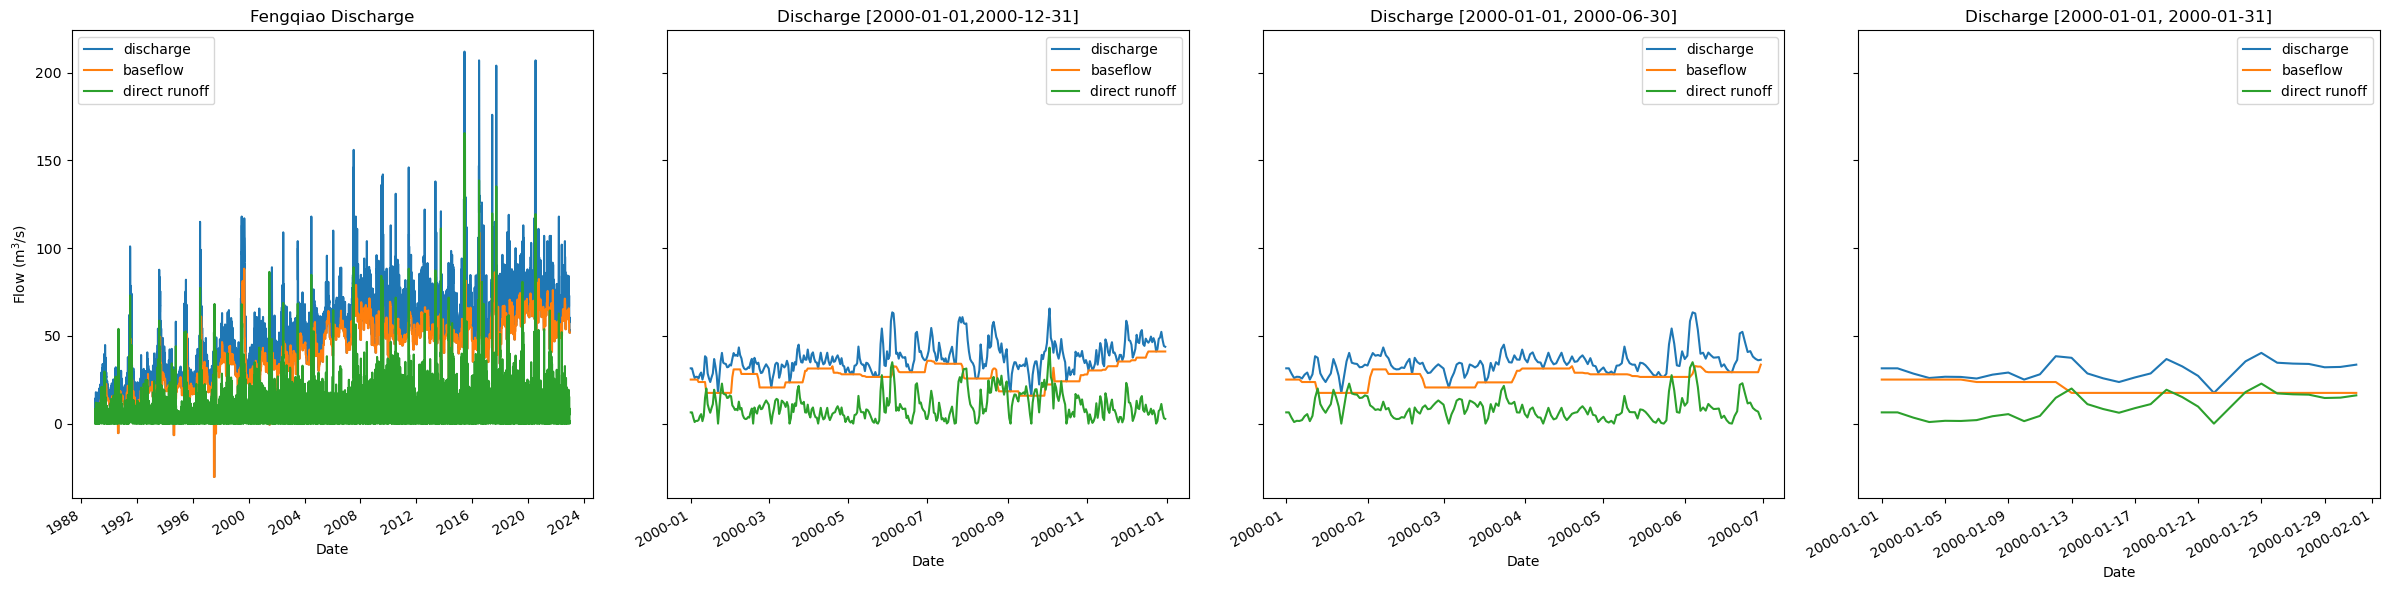

In [12]:
window_plot(10)

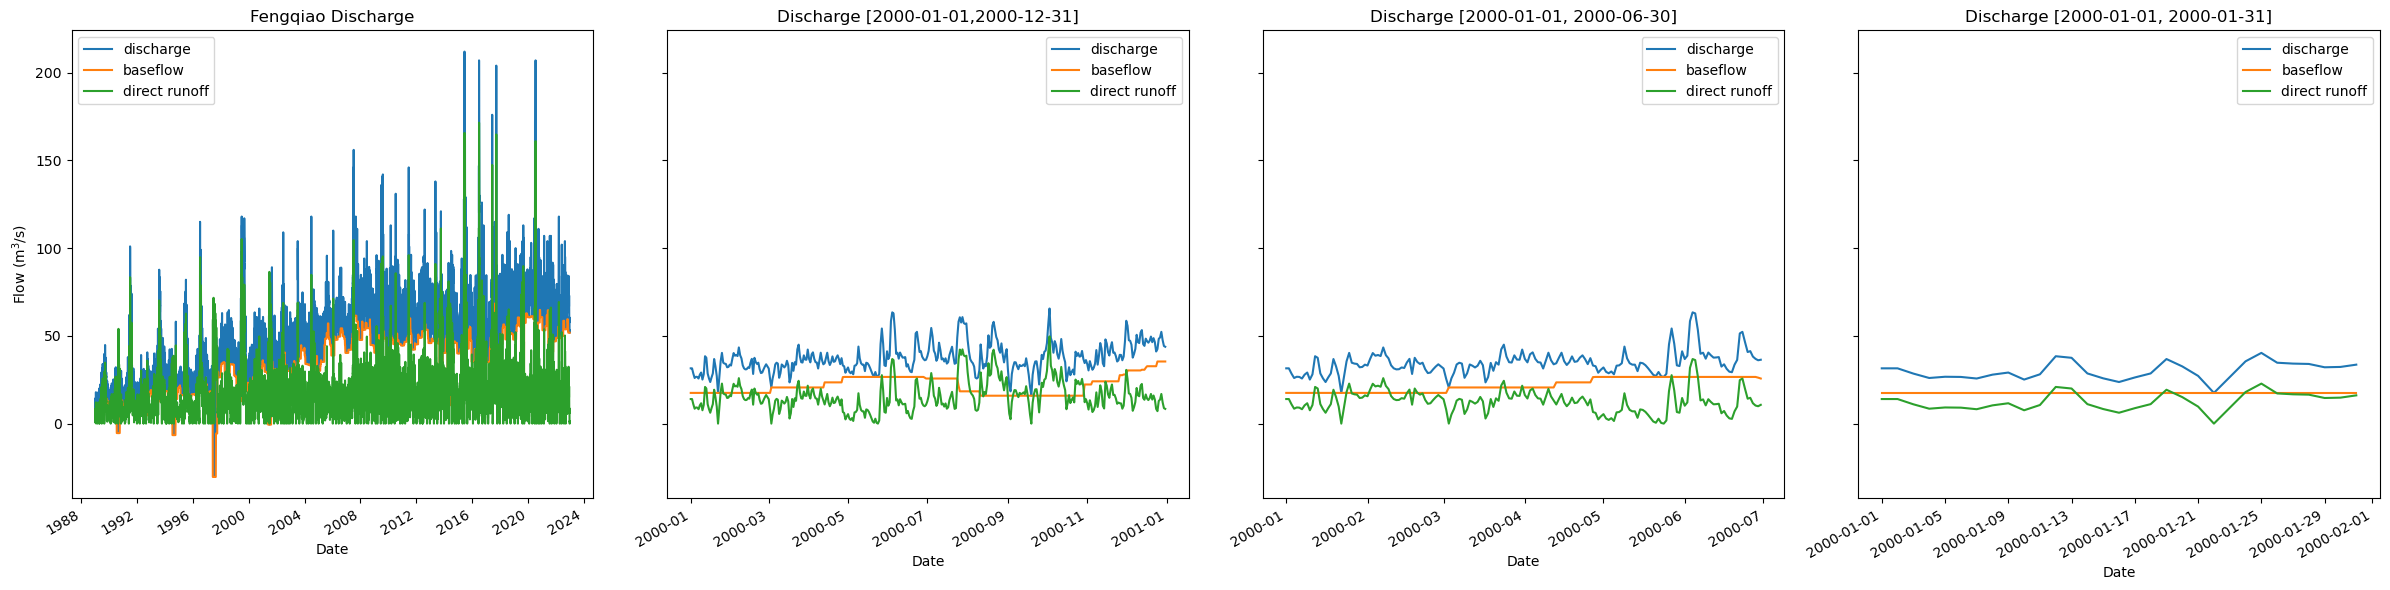

In [18]:
window_plot(40)

通过观测window_size的尺寸5,10,20，发现window_size=5时，径流分离合理性较好，因此选择此方案。

In [14]:
baseflow_fengqiao, direct_runoff_fengqiao = baseflow_separation(fengqiao['discharge'], window_size=20)

fengqiao['baseflow'] = baseflow_fengqiao
fengqiao['direct_runoff'] = direct_runoff_fengqiao

fengqiao.to_csv('../data/intermediate/fengqiao_baseflow_separation.csv')

In [47]:
# +------+    P - ET   +--------+    direct_runoff   +--------+    baseflow     +--------+
# | Rain | --------->  | Tank 1 | ---------------->  | Tank 2 | ------------->  | Tank 3 | ------> Outflow
# +------+             +--------+                    +--------+                 +--------+
#                      (Precipitation               (Direct Runoff)             (Baseflow)
#                      and Evapotranspiration)

这个概念图表明：

1. 第一个水箱（Tank 1）处理降水（P）和蒸散发（ET）。

2. 第二个水箱（Tank 2）处理直接径流（Direct Runoff）。

3. 第三个水箱（Tank 3）处理基流（Baseflow）。

4. 总出流量（Outflow）由直接径流和基流相加得到。

### 城市扩张系数

In [49]:
def tank_model_land_expand(precip, et, k1, k2, A, kc, Land_expand, initial_storage1=0, initial_storage2=0):
    n = len(precip)
    storage1 = np.zeros(n)
    storage2 = np.zeros(n)
    outflow = np.zeros(n)

    storage1[0] = initial_storage1
    storage2[0] = initial_storage2

    # 生成与降水数据长度相同的序列
    expand_factors = np.zeros(n)
    years_per_interval = 5
    for i, expand_factor in enumerate(Land_expand):
        start = i * years_per_interval * 365
        end = min((i + 1) * years_per_interval * 365, n)
        expand_factors[start:end] = expand_factor

    for t in range(1, n):
        # 计算实际蒸散发
        et_actual = et[t] * kc

        # 根据扩张系数调整k1参数
        adjusted_k1 = k1 * (1 + expand_factors[t])

        # 第一个水箱（上游水箱）处理降水和蒸散发
        storage1[t] = storage1[t-1] + precip[t] * A / 86400 - et_actual * A / 86400

        # 当存储量小于0时，将其设置为0
        storage1[t] = max(0, storage1[t])

        # 第二个水箱（下游水箱）处理出流
        inflow = adjusted_k1 * storage1[t]
        storage1[t] -= inflow
        storage2[t] = storage2[t-1] + inflow
        outflow[t] = k2 * storage2[t]
        storage2[t] -= outflow[t]

    return storage1, storage2, outflow

def model_error(k1, k2, A, kc, initial_storage1, initial_storage2, Land_expand, precip, et, discharge):
    _, _, outflow = tank_model(precip, et, k1, k2, A, kc, Land_expand, initial_storage1, initial_storage2)
    mse = mean_squared_error(discharge, outflow)
    return mse

## 基流分离 + 城市扩张模型

扩张系数（Land_expand）加入到第二个水箱和第三个水箱之间，从而影响土地渗透率。

In [50]:
def tank_model_combined(precip, et, k1, k2, k3, A, kc, Land_expand, initial_storage1=0, initial_storage2=0, initial_storage3=0):
    n = len(precip)
    storage1 = np.zeros(n)
    storage2 = np.zeros(n)
    storage3 = np.zeros(n)
    direct_runoff = np.zeros(n)
    baseflow = np.zeros(n)
    outflow = np.zeros(n)

    storage1[0] = initial_storage1
    storage2[0] = initial_storage2
    storage3[0] = initial_storage3

    # 生成与降水数据长度相同的序列
    expand_factors = np.zeros(n)
    years_per_interval = 5
    for i, expand_factor in enumerate(Land_expand):
        start = i * years_per_interval * 365
        end = min((i + 1) * years_per_interval * 365, n)
        expand_factors[start:end] = expand_factor

    for t in range(1, n):
        # 计算实际蒸散发
        et_actual = et[t] * kc

        # 第一个水箱（上游水箱）处理降水和蒸散发
        storage1[t] = storage1[t-1] + precip[t] * A / 86400 - et_actual * A / 86400
        storage1[t] = max(0, storage1[t])

        # 第二个水箱（中游水箱）处理直接径流
        inflow = k1 * storage1[t]
        storage1[t] -= inflow
        storage2[t] = storage2[t-1] + inflow
        direct_runoff[t] = k2 * storage2[t]
        storage2[t] -= direct_runoff[t]

        # 根据扩张系数调整k3参数
        adjusted_k3 = k3 * (1 + expand_factors[t])

        # 第三个水箱（下游水箱）处理基流
        inflow_to_baseflow = adjusted_k3 * storage2[t]
        storage2[t] -= inflow_to_baseflow
        storage3[t] = storage3[t-1] + inflow_to_baseflow
        baseflow[t] = k2 * storage3[t]
        storage3[t] -= baseflow[t]

        # 总出流量
        outflow[t] = direct_runoff[t] + baseflow[t]

    return storage1, storage2, storage3, direct_runoff, baseflow, outflow